In [1]:
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import numpy as np

from mujoco_mpc import batch as batch_lib

# %matplotlib inline

# more legible printing from numpy
np.set_printoptions(precision=6, suppress=True, linewidth=100)

In [2]:
xml = """
<mujoco>
  <option timestep="0.005"/>
  <default>
    <geom solimp="0 0.95 0.001"/>
  </default>

  <visual>
    <headlight ambient=".4 .4 .4" diffuse=".8 .8 .8" specular="0.1 0.1 0.1"/>
    <map znear=".01"/>
    <quality shadowsize="2048"/>
    <global offheight="1024" offwidth="1024"/>
  </visual>

  <asset>
    <texture name="skybox" type="skybox" builtin="gradient" rgb1="0 0 0" rgb2="0 0 0"
             width="800" height="800" mark="random" markrgb="0 0 0"/>
  </asset>

  <asset>
      <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
      <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
      <material name="self" rgba=".7 .5 .3 1"/>
  </asset>

  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <camera pos="-0.079 -0.587 0.400" xyaxes="0.951 -0.310 0.000 0.133 0.410 0.902"/>
    <geom name="ground" type="plane" pos="0 0 0" size=".3 .3 .1" material="grid"/>
    <geom size=".07" pos="-.03 0.03 0"/>
    <body name="m1" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m2" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m3" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m4" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m5" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m6" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m7" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="m8" mocap="true" pos="0.1 0.1 0.1">
      <geom type="sphere" size="0.0075" contype="0" conaffinity="0" rgba="1 0 0 0.5"/>
    </body>
    <body name="root" pos="0 0 0.25">
      <joint type="free"/>
      <geom type="box" size=".05 .05 .05" material="self" mass="1.0"/>
      <site name="corner1" type="sphere" size="0.05" rgba="1 0 0 0" pos=".05 .05 .05"/>
      <site name="corner2" type="sphere" size="0.05" rgba="1 0 0 0" pos="-.05 .05 .05"/>
      <site name="corner3" type="sphere" size="0.05" rgba="1 0 0 0" pos=".05 -.05 .05"/>
      <site name="corner4" type="sphere" size="0.05" rgba="1 0 0 0" pos=".05 .05 -.05"/>
      <site name="corner5" type="sphere" size="0.05" rgba="1 0 0 0" pos="-.05 -.05 .05"/>
      <site name="corner6" type="sphere" size="0.05" rgba="1 0 0 0" pos=".05 -.05 -.05"/>
      <site name="corner7" type="sphere" size="0.05" rgba="1 0 0 0" pos="-.05 .05 -.05"/>
      <site name="corner8" type="sphere" size="0.05" rgba="1 0 0 0" pos="-.05 -.05 -.05"/>
    </body>
  </worldbody>

  <sensor>
    <!-- corner positions -->
    <framepos name="corner_position1" objtype="site" objname="corner1"/>
    <framepos name="corner_position2" objtype="site" objname="corner2"/>
    <framepos name="corner_position3" objtype="site" objname="corner3"/>
    <framepos name="corner_position4" objtype="site" objname="corner4"/>
    <framepos name="corner_position5" objtype="site" objname="corner5"/>
    <framepos name="corner_position6" objtype="site" objname="corner6"/>
    <framepos name="corner_position7" objtype="site" objname="corner7"/>
    <framepos name="corner_position8" objtype="site" objname="corner8"/>
  </sensor>
</mujoco>
"""

In [3]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=720, width=720)

# enable joint visualization option:
scene_option = mujoco.MjvOption()

In [6]:
# random seed
np.random.seed(0)

T = 200

# trajectories
qpos = np.zeros((model.nq, T))
qvel = np.zeros((model.nv, T))
qacc = np.zeros((model.nv, T))
ctrl = np.zeros((model.nu, T))
qfrc = np.zeros((model.nv, T))
sensor = np.zeros((model.nsensordata, T))
noisy_sensor = np.zeros((model.nsensordata, T))
time = np.zeros(T)

# rollout
mujoco.mj_resetData(model, data)

# frames
frames = []
FPS = 1.0 / model.opt.timestep

# simulate
for t in range(T):
  # forward evaluation
  mujoco.mj_forward(model, data)

  # cache
  qpos[:, t] = data.qpos
  qvel[:, t] = data.qvel
  qacc[:, t] = data.qacc
  ctrl[:, t] = data.ctrl
  qfrc[:, t] = data.qfrc_actuator
  sensor[:, t] = data.sensordata
  time[t] = data.time

  # noisy sensor
  noisy_sensor[:, t] = sensor[:, t] + np.random.normal(
      scale=2.5e-3, size=model.nsensordata
  )

  # set mocap
  for i in range(8):
    data.mocap_pos[i, :] = noisy_sensor[(3 * i) : (3 * (i + 1)), t]

  # Euler
  mujoco.mj_Euler(model, data)

  # render and save frames
  renderer.update_scene(data, camera=0, scene_option=scene_option)
  pixels = renderer.render()
  frames.append(pixels)

In [7]:
media.show_video(frames, fps=0.25 * FPS)

I0000 00:00:1695066987.892152 2538899 batch_server.cc:50] Server listening on [::]:37387


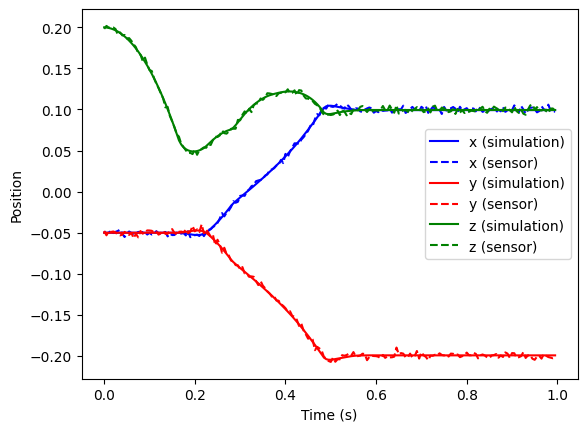

In [8]:
# corner sensor
sensor_index = 7

# plot
fig = plt.figure()
plt.plot(
    time, sensor[0 + 3 * sensor_index, :], color="blue", label="x (simulation)"
)
plt.plot(
    time,
    noisy_sensor[0 + 3 * sensor_index, :],
    ls="--",
    color="blue",
    label="x (sensor)",
)

plt.plot(
    time, sensor[1 + 3 * sensor_index, :], color="red", label="y (simulation)"
)
plt.plot(
    time,
    noisy_sensor[1 + 3 * sensor_index, :],
    ls="--",
    color="red",
    label="y (sensor)",
)

plt.plot(
    time, sensor[2 + 3 * sensor_index, :], color="green", label="z (simulation)"
)
plt.plot(
    time,
    noisy_sensor[2 + 3 * sensor_index, :],
    ls="--",
    color="green",
    label="z (sensor)",
)

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Position")

# initialize estimator
configuration_length = T
estimator = batch_lib.Batch(
    model=model,
    configuration_length=configuration_length,
)


In [9]:
# initialize estimator
configuration_length = T
estimator = batch_lib.Batch(
    model=model,
    configuration_length=configuration_length,
)

# random seed
np.random.seed(0)

# initialization
qinit = np.zeros((model.nq, configuration_length))
for t in range(configuration_length):
  # perturbed initial configuration
  q = np.array(qpos[:, t])
  dq = np.hstack([
      np.random.normal(size=3, scale=1.0e-2),
      np.random.normal(size=3, scale=1.0e-1),
  ])
  mujoco.mj_integratePos(model, q, dq, 1.0)
  qinit[:, t] = q

# set data
for t in range(configuration_length):
  # unpack
  qt = qinit[:, t]
  st = noisy_sensor[:, t]
  ft = qfrc[:, t]

  # set data
  data_ = estimator.data(
      t, configuration=qt, sensor_measurement=st, force_measurement=ft
  )

# set weight
estimator.noise(
    sensor=np.full(model.nsensor, 1.0e-1), process=np.full(model.nv, 1.0e-6)
)

# set settings
estimator.settings(
    sensor_flag=True,
    force_flag=True,
    max_smoother_iterations=1000,
    max_search_iterations=1000,
    regularization_initial=1.0e-6,
    gradient_tolerance=1.0e-5,
    cost_tolerance=1.0e-16,
    last_step_position_sensors=True,
    last_step_velocity_sensors=True,
)

# optimize
estimator.optimize()

# costs
estimator.print_cost()

# status
estimator.print_status()

I0000 00:00:1695067027.843333 2539532 batch_server.cc:50] Server listening on [::]:46283


cost:
  [total]   =  0.0002547660277078643
     prior  =  0.0
     sensor =  0.0002492962321715823
     force  =  5.469795536281995e-06
  (initial  =  9800.474129906544 )
status:
   search iterations   =  337
   smoother iterations =  37
   step size           =  1.0
   regularization      =  316.22776601683825
   gradient norm       =  9.151987027100039e-06
- solve status =  SOLVED


In [10]:
# get optimized trajectories
qopt = np.zeros((model.nq, configuration_length))
vopt = np.zeros((model.nv, configuration_length))
aopt = np.zeros((model.nv, configuration_length))
sopt = np.zeros((model.nsensordata, configuration_length))

for t in range(configuration_length):
  data_ = estimator.data(t)
  qopt[:, t] = data_["configuration"]
  sopt[:, t] = data_["sensor_prediction"]
  if t == 0:
    continue
  vopt[:, t] = data_["velocity"]
  if t == configuration_length - 1:
    continue
  aopt[:, t] = data_["acceleration"]

Text(0, 0.5, 'Configuration')

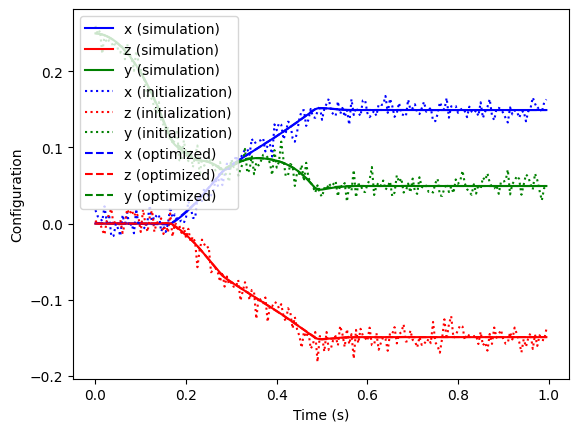

In [11]:
## configuration plots

# plot
fig = plt.figure()

# configuration
plt.plot(time, qpos[0, :], label="x (simulation)", color="blue")
plt.plot(time, qpos[1, :], label="z (simulation)", color="red")
plt.plot(time, qpos[2, :], label="y (simulation)", color="green")

# initialized configurations
plt.plot(time, qinit[0, :], ls=":", label="x (initialization)", color="blue")
plt.plot(time, qinit[1, :], ls=":", label="z (initialization)", color="red")
plt.plot(time, qinit[2, :], ls=":", label="y (initialization)", color="green")

# # optimized configurations
plt.plot(time, qopt[0, :], ls="--", label="x (optimized)", color="blue")
plt.plot(time, qopt[1, :], ls="--", label="z (optimized)", color="red")
plt.plot(time, qopt[2, :], ls="--", label="y (optimized)", color="green")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Configuration")

Text(0, 0.5, 'Orientation')

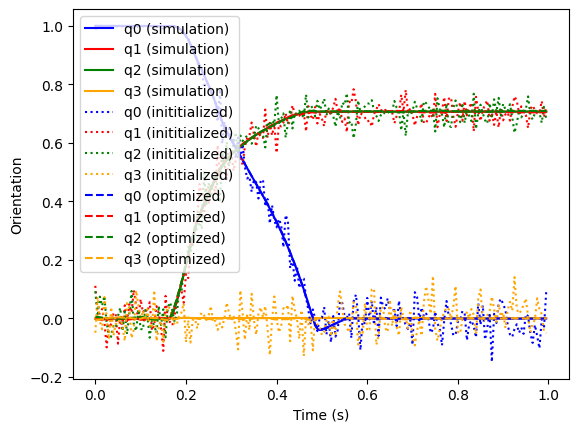

In [12]:
## orientation plots

# plot
fig = plt.figure()

# simulation
plt.plot(time, qpos[3, :], label="q0 (simulation)", color="blue")
plt.plot(time, qpos[4, :], label="q1 (simulation)", color="red")
plt.plot(time, qpos[5, :], label="q2 (simulation)", color="green")
plt.plot(time, qpos[6, :], label="q3 (simulation)", color="orange")

# initialized configurations
plt.plot(time, qinit[3, :], ls=":", label="q0 (inititialized)", color="blue")
plt.plot(time, qinit[4, :], ls=":", label="q1 (inititialized)", color="red")
plt.plot(time, qinit[5, :], ls=":", label="q2 (inititialized)", color="green")
plt.plot(time, qinit[6, :], ls=":", label="q3 (inititialized)", color="orange")

# optimized configurations
plt.plot(time, qopt[3, :], ls="--", label="q0 (optimized)", color="blue")
plt.plot(time, qopt[4, :], ls="--", label="q1 (optimized)", color="red")
plt.plot(time, qopt[5, :], ls="--", label="q2 (optimized)", color="green")
plt.plot(time, qopt[6, :], ls="--", label="q3 (optimized)", color="orange")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Orientation")


Text(0, 0.5, 'Velocity')

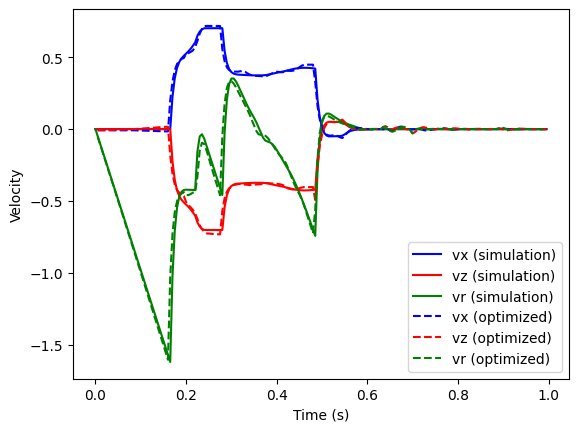

In [13]:
## velocity plots

# plot
fig = plt.figure()

# configuration
plt.plot(time, qvel[0, :], label="vx (simulation)", color="blue")
plt.plot(time, qvel[1, :], label="vz (simulation)", color="red")
plt.plot(time, qvel[2, :], label="vr (simulation)", color="green")

# optimized configurations
plt.plot(
    time[1:configuration_length],
    vopt[0, 1:configuration_length],
    ls="--",
    label="vx (optimized)",
    color="blue",
)
plt.plot(
    time[1:configuration_length],
    vopt[1, 1:configuration_length],
    ls="--",
    label="vz (optimized)",
    color="red",
)
plt.plot(
    time[1:configuration_length],
    vopt[2, 1:configuration_length],
    ls="--",
    label="vr (optimized)",
    color="green",
)

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity")

Text(0, 0.5, 'Acceleration')

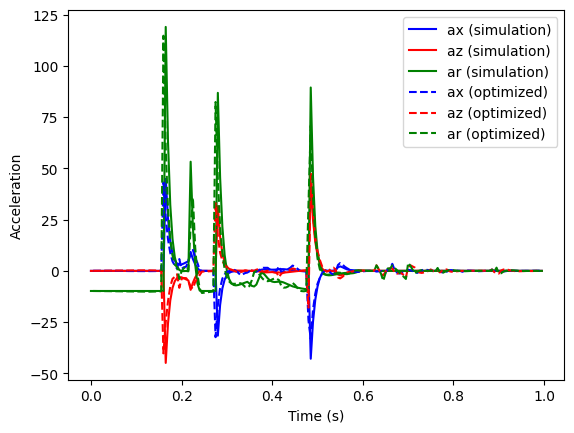

In [14]:
## acceleration plots

# plot
fig = plt.figure()

# configuration
plt.plot(time, qacc[0, :], label="ax (simulation)", color="blue")
plt.plot(time, qacc[1, :], label="az (simulation)", color="red")
plt.plot(time, qacc[2, :], label="ar (simulation)", color="green")

# optimized configurations
plt.plot(
    time[1 : configuration_length - 1],
    aopt[0, 1 : configuration_length - 1],
    ls="--",
    label="ax (optimized)",
    color="blue",
)
plt.plot(
    time[1 : configuration_length - 1],
    aopt[1, 1 : configuration_length - 1],
    ls="--",
    label="az (optimized)",
    color="red",
)
plt.plot(
    time[1 : configuration_length - 1],
    aopt[2, 1 : configuration_length - 1],
    ls="--",
    label="ar (optimized)",
    color="green",
)

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")

In [15]:
# frames optimized
frames_opt = frames.copy()

# simulate
for t in range(configuration_length - 1):
  # initializaiton
  data.qpos = qinit[:, t]
  mujoco.mj_differentiatePos(
      model, data.qvel, model.opt.timestep, qinit[:, t], qinit[:, t + 1]
  )

  # forward
  mujoco.mj_forward(model, data)

  # set mocap
  for i in range(8):
    data.mocap_pos[i, :] = sopt[(i * 3) : ((i + 1) * 3), t + 1]

  # render and save frames
  renderer.update_scene(data, camera=0, scene_option=scene_option)
  pixels_init = renderer.render()

  # set configuration
  data.qpos = qopt[:, t + 1]
  data.qvel = vopt[:, t + 1]

  # forward
  mujoco.mj_forward(model, data)

  # don't visualize mocap for initialization
  data.mocap_pos = np.zeros((8, 3))

  # render and save frames
  renderer.update_scene(data, camera=0, scene_option=scene_option)
  pixels = renderer.render()

  frames_opt[t] = np.hstack((frames_opt[t], pixels_init, pixels))

In [16]:
# display video
media.show_video(
    frames_opt[: configuration_length - 2], fps=0.2 * FPS, loop=False
)